In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

In [114]:
def generate_data(n_samples, noise_level, seed=15, display=False):
#     centers = [[0.0, 0.0], [2.0, 2.0]]
#     clusters_std = [0.4, 0.4]
#     X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
#                       centers=centers,
#                       cluster_std=clusters_std,
#                       random_state=seed,
#                       shuffle=False)
    X = np.random.normal(loc=0, scale=1, size=[n_samples, 2])
    y = np.array([1 if x[1] > np.sin(2 * x[0]) else 0 for x in X])

    # Split into train, test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
    # Randomly flip a percentage of training labels
    n = len(y_train)
    y_train = np.array([abs(1 - y_train[i]) if i in random.sample(range(n), int(noise_level * n)) else y_train[i] for i in range(n)])

    if display:
        plt.scatter(X_train[:,0], X_train[:,1], c=['#516091' if y==1 else '#A9ECA2' for y in y_train])
#     plt.savefig('distributional_robustness_classification.png')
    y_train = y_train.reshape(-1, 1)
    X_train = torch.tensor(X_train, dtype=torch.float)
    y_train = torch.tensor(y_train, dtype=torch.float)
    
    y_test = y_test.reshape(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float)
    y_test = torch.tensor(y_test, dtype=torch.float)
    
    return X_train, X_test, y_train, y_test

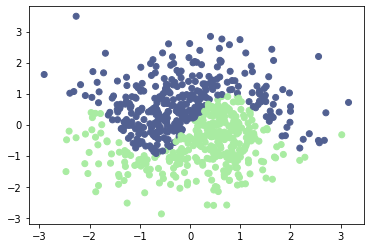

In [115]:
X_train, X_test, y_train, y_test = generate_data(1000, 0, display=True)

In [2]:
import sys
sys.path.insert(0, '/Users/william/Documents/CMU/Research/RiskSensitiveLearning/SupervisedLearning/objectives')
import cvar, human_aligned_risk, entropic_risk, trimmed_risk, mean_variance

In [5]:
input_size = 2
hidden_size = 12
output_size = 2

class LinearMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LinearMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)
#         self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
        return x
    
epochs = 2000
learning_rate = 1e-2

In [6]:
seeds = [15, 30]
alphas = [0.5, 0.7, 0.8]
objectives = {
    'Expected Value': nn.CrossEntropyLoss(),
    'CVaR': cvar.CVaR(a=0.45), # We look at bottom 25% of losses
    'Entropic Risk': entropic_risk.EntropicRisk(t=-1),
    'Human-Aligned Risk': human_aligned_risk.HumanAlignedRisk(a=0.1, b=0.8),
    'Inverted CVaR': cvar.CVaR(a=0.95, inverted=True), # We look at top 75% of losses
    'Mean-Variance': mean_variance.MeanVariance(c=-.1),
    'Trimmed Risk': trimmed_risk.TrimmedRisk(a=0.05),
}

for alpha in alphas:
    for objective in objectives.keys():
        overall_accuracies = []
        alpha_accuracies = []
        
        for seed in seeds:
            X_train, X_test, y_train, y_test = generate_data(1000, 0, seed=seed)
            # Get objective
            criterion = objectives[objective]

            # Reset random seeds for comparaison.
            torch.manual_seed(seed)
            random.seed(seed)
            np.random.seed(seed)

            model = LinearMLP(input_size, hidden_size, output_size)
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

            # Train
            model.train()
            for epoch in range(epochs):
                # clear the gradients so they wont accumulate
                optimizer.zero_grad()

                output = model(X_train)
                loss = criterion(output, y_train.squeeze(1).type(torch.LongTensor))

                # calculate gradient
                loss.backward()

                # gradient descent
                optimizer.step()
            
#             # define bounds of the domain
#             min1, max1 = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
#             min2, max2 = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

#             # define the x and y scale
#             x1grid = np.arange(min1, max1, 0.1)
#             x2grid = np.arange(min2, max2, 0.1)

#             # create all of the lines and rows of the grid
#             xx, yy = np.meshgrid(x1grid, x2grid)
#             # flatten each grid to a vector
#             r1, r2 = xx.flatten(), yy.flatten()
#             r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
#             # horizontal stack vectors to create x1,x2 input for the model
#             grid = np.hstack((r1,r2))

#             pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
#             pred = pred.detach().numpy()

#             # keep probabilities for class 0
#             pred = pred[:, 0]
#             # reshape the predictions back into a grid
#             zz = pred.reshape(xx.shape)

#             # plot the grid of x, y and z values as a surface
#             c = plt.contourf(xx, yy, zz, cmap='RdBu')
#             # add a legend, called a color bar
#             plt.colorbar(c)

            model.eval()
    
            criterion = nn.CrossEntropyLoss(reduction='none')
        
            correct = 0
            incorrect = 0
            with torch.no_grad():
                output = model(X_test)
                
                losses = criterion(output, y_test.squeeze(1).type(torch.LongTensor))
                sorted_losses, sorted_idxs = torch.sort(losses, dim=0)
                worst_idxs = sorted_idxs[int(alpha * len(sorted_idxs)):]
                
                pred = torch.argmax(F.softmax(output, dim=1), dim=1)
                overall_accuracy = sum(1 for x, y in zip(pred, y_test) if x == y) / len(pred)
                worst_1_minus_alpha_accuracy = sum(1 for x, y in zip(pred[worst_idxs], y_test[worst_idxs]) if x == y) / len(pred[worst_idxs])
                overall_accuracies.append(overall_accuracy)
                alpha_accuracies.append(worst_1_minus_alpha_accuracy)
        print('Objective: {}, Accuracy: {}, Worst {}% Accuracy: {}'.format(objective, np.mean(overall_accuracies), 1-alpha, np.mean(alpha_accuracies)))

NameError: name 'generate_data' is not defined